In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

df = pd.read_csv(r"C:\Users\jiaha\Desktop\Projects\Medical Dataset\stroke data.csv")
df.smoking_status.replace(['never smoked', 'formerly smoked', 'smokes'], [0, 1, 2], inplace = True) # ordinal variable
df.head()

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
0,1,Male,3.0,No,0,0,A,Rural,95.12,18.0,1,99.35,95.12,NaN,0
1,2,Male,58.0,Yes,1,0,B,Urban,87.96,39.2,1,99.70,87.96,0.0,0
2,3,Female,8.0,No,0,0,B,Urban,110.89,17.6,0,96.35,110.89,NaN,0
3,4,Female,70.0,Yes,0,0,B,Rural,69.04,35.9,0,95.52,69.04,1.0,0
4,5,Male,14.0,No,0,0,C,Rural,161.28,19.1,1,95.10,161.28,NaN,0


# Inital EDA

First off, I started by looking for any errors in the data/missing data and in general just to get to know what the data looks like.

<Axes: >

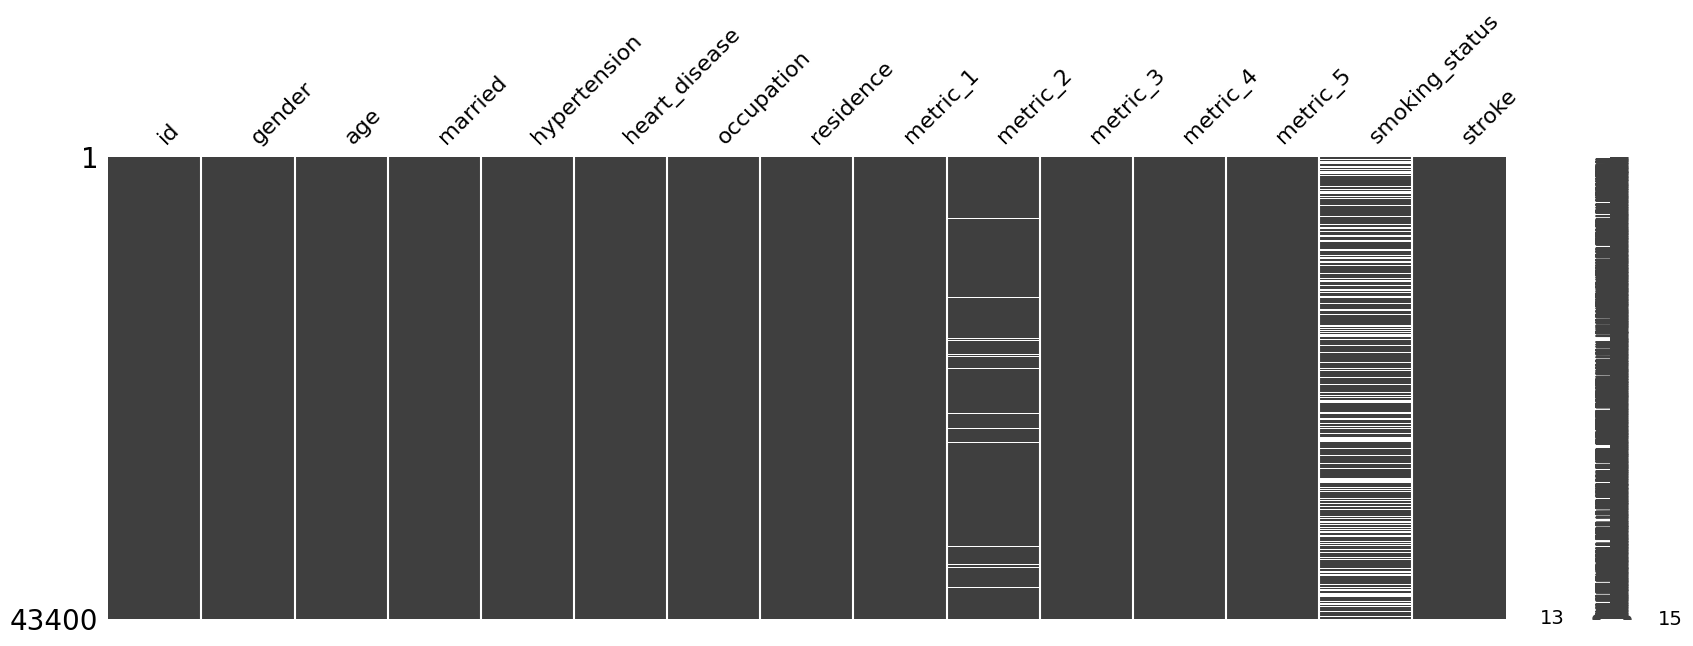

In [62]:
mno.matrix(df, figsize = (20, 6))

We see that there are a few missing data in metric_2 as well as quite a bit in smoking_status.

For metric_2, after further analysis of the distributions as well as its relation to some key variables, I decided to drop those missing metric_2 as they also account for very low proportion of the total dataset.

In [63]:
df = df.dropna(subset=['metric_2'])

We will get back to the issue of missing data in smoking status later. Other potential issues to worry about are data that may be clearly off. For this I noticed in looking through the distributions that age had this issue.

Text(0.5, 1.0, 'Age histogram')

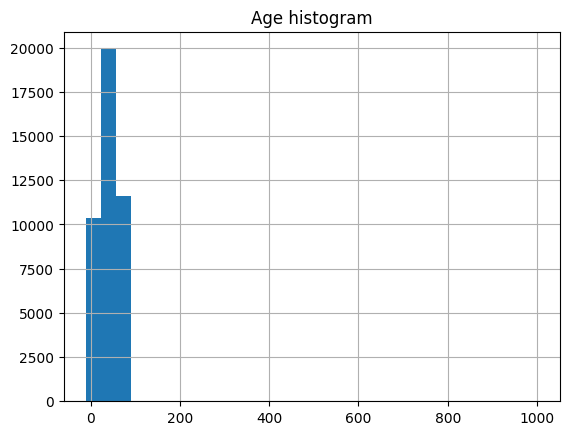

In [64]:
df.age.hist(bins = 30)
plt.title('Age histogram')

In [65]:
df[(df.age < 0) | (df.age > 82)]
# none of these are real ages, let us remove all of them

,id,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,metric_5,smoking_status,stroke
6123,6124,Female,1000.0,Yes,1,1,B,Rural,74.38,30.0,1,97.75,74.38,1.0,0
19352,19353,Male,-10.0,Yes,0,0,B,Rural,180.48,40.1,1,96.62,180.48,2.0,0
36604,36605,Female,999.0,No,0,0,A,Rural,58.24,17.6,0,96.14,58.24,NaN,0


None of these are real ages, let us remove all of them

In [66]:
df = df[(df.age > 0) & (df.age < 83)]

array([[<Axes: title={'center': 'metric_1'}>]], dtype=object)

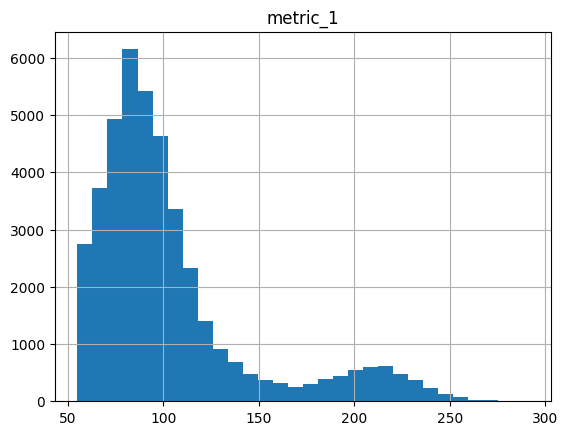

In [67]:
df.hist('metric_1', bins = 30)

array([[<Axes: title={'center': 'metric_5'}>]], dtype=object)

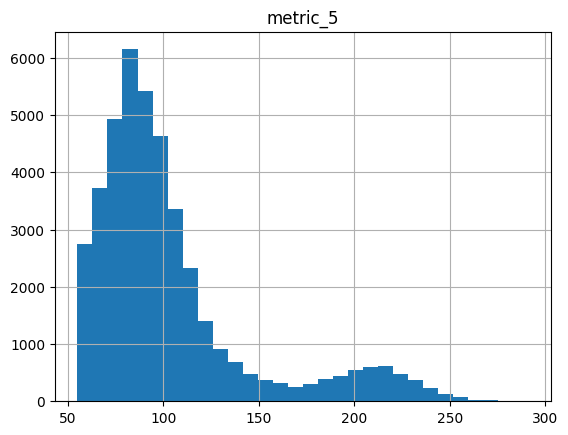

In [68]:
df.hist('metric_5', bins = 30)

Not only that, there was a redundant column where metric_1 and metric_5 were identical and so I removed metric_5

In [69]:
df = df.drop(columns= ['metric_5'])

Back to the issue with smoking status, the first interesting thing I noticed was how much of the missing data was related to age.

Text(0.5, 1.0, 'Age vs Missing smoking status')

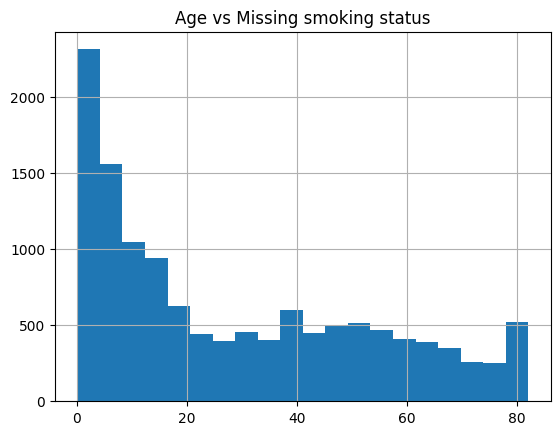

In [70]:
df[df.age < 10].smoking_status.value_counts() # MNAR below age of 10 all NAN

df[(df.smoking_status.isna()) & (df.age < 83)].age.hist(bins = 20)
plt.title('Age vs Missing smoking status')

Text(0.5, 1.0, 'Age Distribution of the Data')

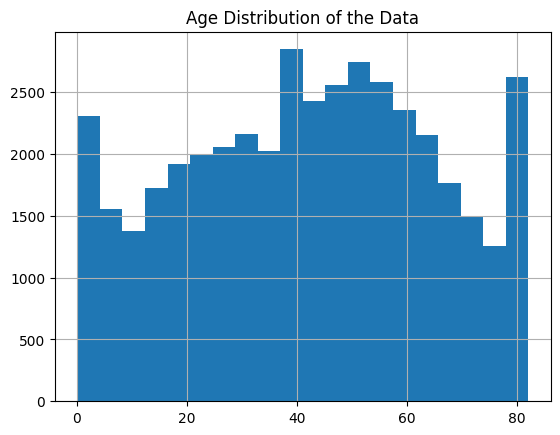

In [71]:
df[df.age < 83].age.hist(bins = 20)
plt.title('Age Distribution of the Data')

C:\Users\jiaha\AppData\Local\Temp\ipykernel_14908\3953927336.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[df.age > 0].groupby('age').mean().smoking_status.plot()


Text(0.5, 1.0, 'Age vs Proprtion of Available Smoking Status Data')

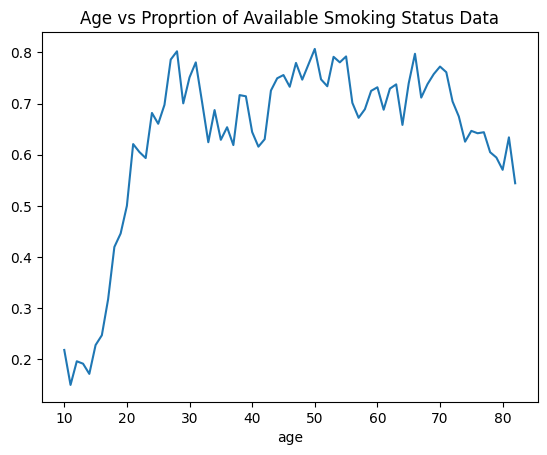

In [72]:
df[df.age > 0].groupby('age').mean().smoking_status.plot()
plt.title('Age vs Proprtion of Available Smoking Status Data')

For this reason, I impute the data in bins based on age and then used KNN to get their classifications.

In [73]:
# Temp for now to deal with categorical vars errors with KNN imputation
df.gender.replace(['Female', 'Male', 'Other'], [0, 1, 2], inplace=True)
df.married.replace(['No', 'Yes'], [0, 1], inplace= True)
df.occupation.replace(['A', 'B', 'C', 'D', 'E'], [0, 1, 2, 3, 4], inplace=True)
df.residence.replace(['Rural', 'Urban'], [0, 1], inplace=True)
df.smoking_status.replace(['never smoked', 'formerly smoked', 'smokes'], [0, 1, 2], inplace = True)

imputer = KNNImputer(n_neighbors=5, weights="distance")
a = imputer.fit_transform(df[df.age < 12])
b = imputer.fit_transform(df[(df.age >= 12) & (df.age < 17)])
c = imputer.fit_transform(df[(df.age >= 17) & (df.age < 20)])
d = imputer.fit_transform(df[(df.age >= 20) & (df.age < 70)])
e = imputer.fit_transform(df[(df.age >= 70)])

a  = pd.DataFrame(a, columns= list(df.columns))
b  = pd.DataFrame(b, columns= list(df.columns))
c  = pd.DataFrame(c, columns= list(df.columns))
d  = pd.DataFrame(d, columns= list(df.columns))
e  = pd.DataFrame(e, columns= list(df.columns))

data = pd.concat([a, b])
data = pd.concat([data, c])
data = pd.concat([data, d])
data = pd.concat([data, e])
data = data.sort_values('id')

data.smoking_status = data.smoking_status.round(0)
data = data.reset_index().drop(columns = ['index', 'id'])
data

,gender,age,married,hypertension,heart_disease,occupation,residence,metric_1,metric_2,metric_3,metric_4,smoking_status,stroke
0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,95.12,18.0,1.0,99.35,1.0,0.0
1,1.0,58.0,1.0,1.0,0.0,1.0,1.0,87.96,39.2,1.0,99.70,0.0,0.0
2,0.0,8.0,0.0,0.0,0.0,1.0,1.0,110.89,17.6,0.0,96.35,1.0,0.0
3,0.0,70.0,1.0,0.0,0.0,1.0,0.0,69.04,35.9,0.0,95.52,1.0,0.0
4,1.0,14.0,0.0,0.0,0.0,2.0,0.0,161.28,19.1,1.0,95.10,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41930,0.0,10.0,0.0,0.0,0.0,0.0,1.0,58.64,20.4,0.0,97.23,0.0,0.0
41931,0.0,56.0,1.0,0.0,0.0,4.0,1.0,213.61,55.4,0.0,97.81,1.0,0.0
41932,0.0,82.0,1.0,1.0,0.0,1.0,1.0,91.94,28.9,0.0,95.35,1.0,0.0
41933,1.0,40.0,1.0,0.0,0.0,1.0,1.0,99.16,33.2,0.0,96.40,0.0,0.0


While we are at it, let's also see if there are any issues with colinearity.

We find some relation between age and marriage but the rest do seem fine.

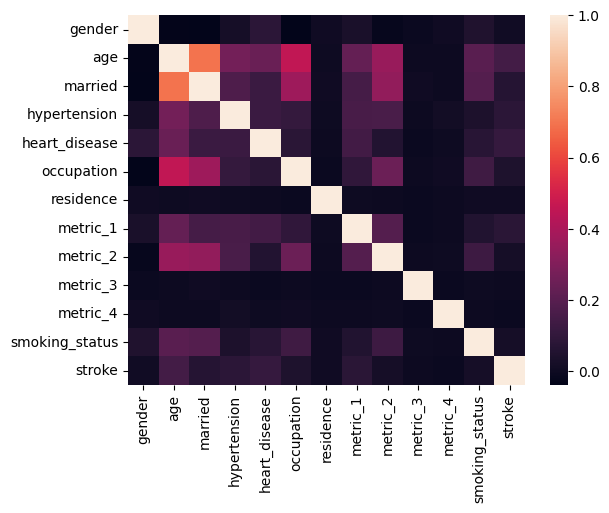

In [74]:
sns.heatmap(data.corr())
plt.show()

Something else peculiar that I notced was that metric 4 had rather high counts for very specific values.

But, I couldn't find much of where there might be some issue with them. Perhaps are more thorough examination may lead to something, but for now I will leave it as is. 

Text(0.5, 1.0, 'Density plot of  metric_4 relative to stroke')

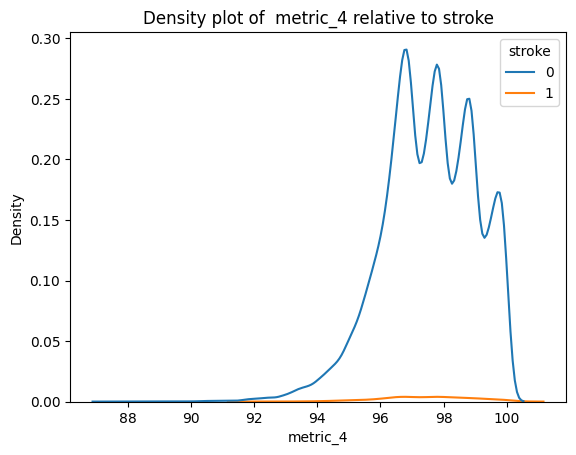

In [75]:
sns.kdeplot(data=df, x="metric_4", hue="stroke")
plt.title('Density plot of  metric_4 relative to stroke')

In [76]:
df.metric_4.value_counts().head(20)

96.92    185
97.85    179
97.96    175
97.95    174
96.90    173
96.83    169
96.99    165
96.93    164
96.94    162
97.89    161
97.90    161
96.98    159
97.97    157
96.96    156
96.97    156
96.89    154
96.86    154
96.81    153
97.99    151
96.95    151
Name: metric_4, dtype: int64

In [77]:
data.occupation.replace([0, 1, 2, 3, 4], ['A', 'B', 'C', 'D', 'E'], inplace=True)
data.gender.replace([0, 1, 2] , ['Female', 'Male', 'Other'], inplace=True)
data.married.replace([0, 1], ['No', 'Yes'], inplace= True)
data.occupation.replace([0, 1, 2, 3, 4], ['A', 'B', 'C', 'D', 'E'], inplace=True)
data.residence.replace([0, 1], ['Rural', 'Urban'], inplace=True)

Now we are ready to do GLM. Since the responce variable is binary, I chose to use binomial with logit link. For feature selection, I tried to do backwards selection based on p-values of the columns above 0.2 to give extra room for a few more vars. In r i would probably try a glmnet instead.

In [78]:
f = 'stroke ~ C(gender) + age + C(married) + hypertension + heart_disease + C(occupation) + C(residence) + metric_1 + metric_2 + metric_3 + metric_4 + smoking_status'
model = smf.glm(formula = f, data=data, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                41935
Model:                            GLM   Df Residuals:                    41918
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2714.5
Date:                Sun, 09 Apr 2023   Deviance:                       5429.0
Time:                        23:25:27   Pearson chi2:                 3.41e+04
No. Iterations:                    24   Pseudo R-squ. (CS):            0.02867
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.33

In [79]:
f = 'stroke ~ C(gender) + age + hypertension + heart_disease + C(occupation) + C(residence) + metric_1 + metric_4 + smoking_status'
model = smf.glm(formula = f, data=data, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                41935
Model:                            GLM   Df Residuals:                    41921
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2715.6
Date:                Sun, 09 Apr 2023   Deviance:                       5431.2
Time:                        23:25:27   Pearson chi2:                 3.39e+04
No. Iterations:                    24   Pseudo R-squ. (CS):            0.02861
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -5.48

In [80]:
f = 'stroke ~ age + hypertension + heart_disease + metric_1 + metric_4 + smoking_status'
model = smf.glm(formula = f, data=data, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 stroke   No. Observations:                41935
Model:                            GLM   Df Residuals:                    41928
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2716.7
Date:                Sun, 09 Apr 2023   Deviance:                       5433.3
Time:                        23:25:27   Pearson chi2:                 3.23e+04
No. Iterations:                     9   Pseudo R-squ. (CS):            0.02857
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.7512      2.717     -1.

Now, to segement the people into groups based on percentile - likelihood of potential stroke.

In [81]:
data['exp'] = np.e ** (-4.7541 + 0.0722 * data.age + 0.4171 * data.hypertension + 0.6687 * data.heart_disease + 0.0038 * data.metric_1 - 0.0432 * data.metric_2 + 0.0926 * data.smoking_status)
data['prob'] = data.exp / (1 + data.exp)
data['clsf'] = round(data.prob)
data['group'] = pd.qcut(data.prob, q=5)

data.groupby('group').mean()[['stroke', 'prob', 'clsf']]

C:\Users\jiaha\AppData\Local\Temp\ipykernel_14908\321478869.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('group').mean()[['stroke', 'prob', 'clsf']]


,stroke,prob,clsf
group,,,
"(-0.0007390000000000001, 0.0159]",0.000119,0.009755,0.000000
"(0.0159, 0.0456]",0.000954,0.028092,0.000000
"(0.0456, 0.12]",0.005008,0.077538,0.000000
"(0.12, 0.29]",0.014308,0.191425,0.000000
"(0.29, 0.911]",0.056278,0.492570,0.452844


Decent separation, we see that in each bin, as the group probabilities based on the glm model increases, so too does the stroke rate in the actual data - with separation of about 5.6%.

Now for the sake of just getting a potentially better classifier separation, we can try an xgboost on the data with a grid search for the hyperparameters. Issue with this is that the patterns it finds may not give as much explainibility as GLM would and in this classifier we would also need to keep track of imblanced classes.

In [82]:
data = data.drop(columns=['exp', 'prob', 'clsf', 'group'])
data = pd.get_dummies(data)

X = data.drop(columns=['stroke'])
y = data.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

estimator = xgb.XGBClassifier(objective= 'binary:logistic', nthread=4, seed=42, scale_pos_weight=100)

grid_search = GridSearchCV(estimator=estimator,
                            param_grid={'max_depth': range(2, 10), 'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01, 0.05], 'scale_pos_weight': [20, 50, 100, 150]},
                            scoring = 'roc_auc', n_jobs = 10, cv = 10, verbose=True)

grid_search.fit(X, y)
grid_search.best_estimator_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

In [84]:
data['prob'] = np.transpose(grid_search.predict_proba(X))[1]
data['clsf'] = round(data.prob)
data['group'] = pd.qcut(data.prob, q=5)

data.groupby('group').mean()[['stroke', 'prob', 'clsf']]

,stroke,prob,clsf
group,,,
"(0.00551, 0.00683]",0.000000,0.006730,0.000000
"(0.00683, 0.0797]",0.000953,0.028139,0.000000
"(0.0797, 0.152]",0.005136,0.114480,0.000000
"(0.152, 0.324]",0.013898,0.237968,0.000000
"(0.324, 0.812]",0.057757,0.496227,0.492482


We get relatively similar separation and it is slightly better at about 5.8%.

Definitely try a few other ML models.